# **Movie Recommendation System using Collaborative Filtering, Matrix Factorization with Clustering, and Graph-Based PageRank**


---
## **Introduction**




Reccomendation systems are a core part of modern digital platforms, helping users discover relevant contens such as movies, music or products. By analyzing patterns in user behaviour and preferences, these systems aim to personalize recommendations and improve user satisfaction.


In this project, we aim to build a movie recommendation system using user-movie rating data to predict which movies a user would likely enjoy. We will use the MovieLens 100k dataset, which contains 100,000 ratings from 943 users on 1682 movies during the seven-month period from September 19th,1997 through April 22nd, 1998. While larger datsets like MovieLens 1M or 20M exits, the 100k verseion is chosen because it provides a realistic level of sparsity and diversity while remaining computationally effecient for in-memory applications. This will allow us to focus on algorithmic insights and comparisons rather than runtime constraints.


Our goals of this project are to:
- **Build and compare several recommender models.**
- **Incorporate dimensionality reduction , clustering and graph based methods.**
- **Evaluate and analyze the performance difference between these approaches.**

In [1]:
!pip install kagglehub

In [2]:
# import dependencies
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import networkx as nx
from collections import defaultdict
import random


In [3]:
# download latest version of dataset
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/han./.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1


The MovieLens 100k dataset includes several files containing user-movie rating data, movie metadat, and optional demographic information. For this project, only the key files are used:
- `u.data` which contains user-movie ratings
- `u.item` which provides movies metadata such as title, release date and genre indicators
- `u.user` which provides basic user demographics

Other files such a `u1.base` , `u1.test`, and similar are predefined cross-validation splits provided for benchmarking and hence will not be required in this project. The focus here is on understanding and exploring the core user-movie-rating relationships within the dataset.

In [4]:
# load the datasets into pandas dataframe

# main user-movie ratings data
ratings = pd.read_csv(f"{path}/ml-100k/u.data", sep = '\t' , names= ['user_id', 'item_id', 'rating', 'timestamp'])

# movies metadata
movies = pd.read_csv(f"{path}/ml-100k/u.item", sep = '|',encoding = 'latin-1', names=[
        "movie_id", "title", "release_date", "video_release_date", "imdb_url",
        "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
        "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
        "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ])

# user demographic
users = pd.read_csv(f"{path}/ml-100k/u.user", sep = '|',  names = ['user_id', 'age', 'gender', 'occupation', 'zip_code'])


---
## **Exploratory Data Analysis**


### **1. Ratings Dataset**
The `ratings` dataset contains the main user-movie interactions. Each record reprsents a rating that a specific user gave to a specific movie. It has 4 columns:

- `user_id`: unique identifier for user
- `item_id`: unique identifier for movie
- `rating`: rating value (1-5)
- `timestamp`: Unix timestampe of when the rating was given

We will explore its dataset strucute and basis statistics, analyze rating distributions and activity patterns and visualize rating sparsity to understand data density.

In [5]:
# basic info about ratings
print(f'Shape: {ratings.shape}')
print(f'Unique Users: {ratings.user_id.nunique()}')
print(f'Unique Movies:{ratings.item_id.nunique()}')
print(f'Rating Range: {ratings.rating.min()} - {ratings.rating.max()}')
ratings.head(3)

Shape: (100000, 4)
Unique Users: 943
Unique Movies:1682
Rating Range: 1 - 5


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


Lets take a look at how users normally rate movies. If the data is skewed towards higher ratings, it may indicate rating biasness.

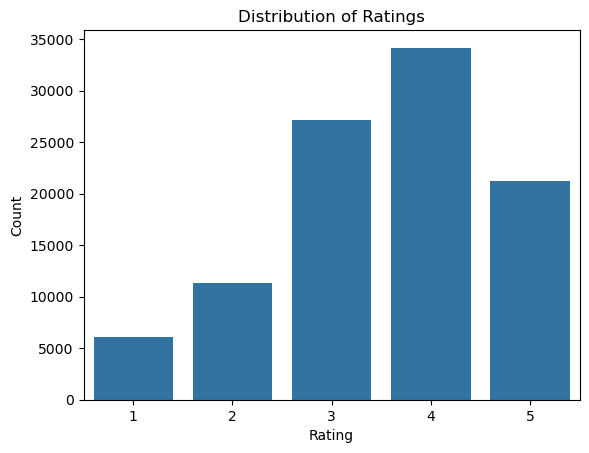

In [6]:
# ratings distribution
sns.countplot(x = 'rating', data = ratings)
plt.title('Distribution of Ratings')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Ratings are right skewed with many higher ratings and fewer lower ratings.




We will now explore:
- How many ratings each user gave (user activity)
- How many ratings each movie recieved (movie popularity)

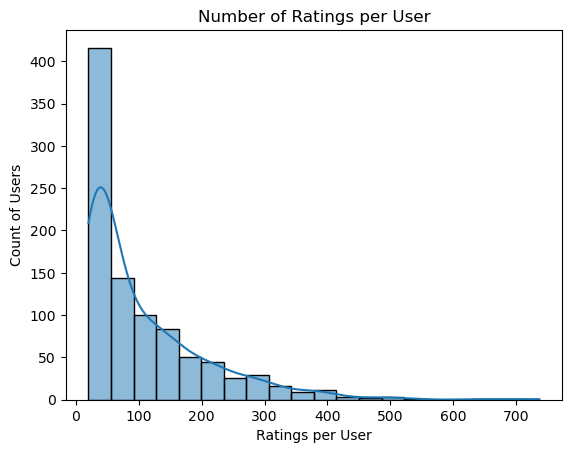

In [7]:
# ratings per user
user_activity = ratings.groupby('user_id')['rating'].count()
sns.histplot(user_activity, bins = 20, kde = True)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings per User")
plt.ylabel("Count of Users")
plt.show()

Only some users rate hundreds of movies, most rate only a few movies.

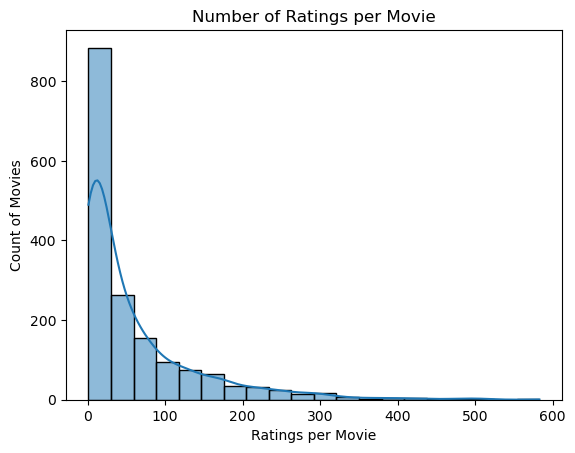

In [8]:
# ratings per movie
movie_popularity = ratings.groupby('item_id')['rating'].count()
sns.histplot(movie_popularity, bins = 20, kde = True)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings per Movie")
plt.ylabel("Count of Movies")
plt.show()

Only a few movies are rated very frequently.

The timestamp column captures when each rating was made. We will convert it to human-readable data and analyze the average rating sentiments per year.

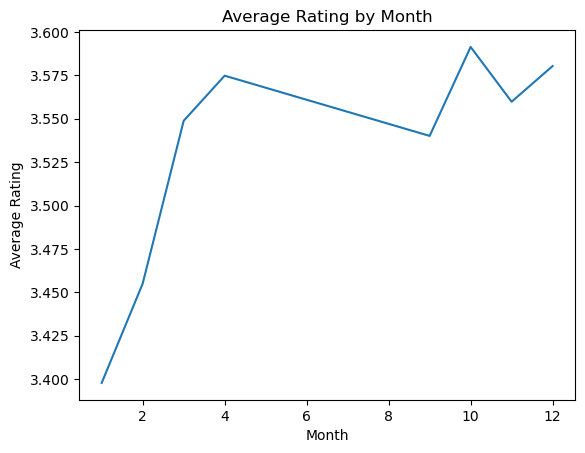

In [9]:
# convert timestampe to datetime
ratings['datetime']= pd.to_datetime(ratings['timestamp'], unit = 's')
ratings['month'] = ratings.datetime.dt.month

# compute average rating per year
monthly_avg = ratings.groupby('month')['rating'].mean()
plt.plot(monthly_avg.index,monthly_avg.values)
plt.title("Average Rating by Month")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()

The timeline of this dataset mostly span 1997-1998. Hence, average rating should stay relatively stable (3.5-4.0). There is no strong temporal shift in user sentiment.

Lastly, lets look into the sparsity of the user-movie rating utility matrix.

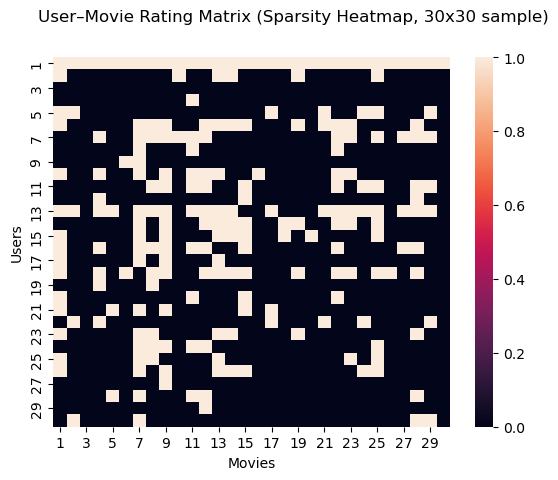


 Sparsity of full matrix is 93.70%


In [10]:
# create user-movie matrix
ratings_matrix = ratings.pivot_table(index = 'user_id', columns = 'item_id', values = 'rating')

# visualize sparsity of a subset
subset = ratings_matrix.iloc[:30,:30]
sns.heatmap(subset.notnull())
plt.suptitle("User–Movie Rating Matrix (Sparsity Heatmap, 30x30 sample)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

# overall sparsisty
total_possible = ratings_matrix.shape[0] * ratings_matrix.shape[1]
actual_ratings = ratings.shape[0]
sparsity = 1 - (actual_ratings/total_possible)
print(f"\n Sparsity of full matrix is {sparsity:.2%}")

### **2. Movies Dataset**

The `movies` dataset contains metadata about each movie. It contains these few columns:

- `movie_id`: unique identifier for the movie
- `title`: movie titile
- `release_date`: release date of movie
- 19 binary genre flags (e.g Action, Comedy, Drama..) indcating movie categories

We will explore dataset structure, analyze movie release years, study genre distribution and popularity, examine which genres tend to receive higher average ratings.

In [11]:
# basic info
print(f'Shape: {movies.shape}')
movies.head(3)

Shape: (1682, 24)


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We will inspect for missing values and the range of release years to understand the dataset's completeness and time coverage.

Missing value per column:
release_date             1
video_release_date    1682
imdb_url                 3
dtype: int64

Earliest release year: 1922.0

Latest release year: 1998.0


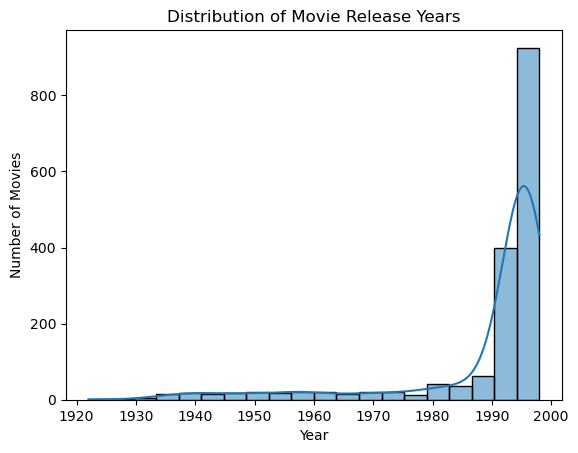

In [12]:
# missing values
print('Missing value per column:')
print(movies.isnull().sum()[movies.isnull().sum() > 0 ])

# convert release_date to datetime
movies['release_date'] = pd.to_datetime(movies['release_date'])

# extract release year
movies['release_year'] = movies['release_date'].dt.year

# earliest and latest release year
print(f'\nEarliest release year: {movies.release_year.min()}')
print(f'\nLatest release year: {movies.release_year.max()}')

# distribution of movie release years
sns.histplot(movies['release_year'], bins = 20,kde = True)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()


Our movies' release years range from 1922 to 1998 with a peak around the 1990s

Each movie can belong to multiple genres (e.g. Toy Story is in Animations,Childrens etc). We will sum across each genre column to see how many movies belong to each category.

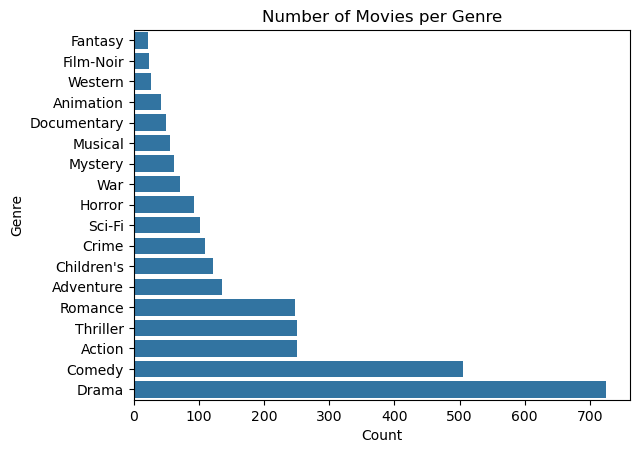

Movies with multiple genres: 849 (50.48%)


In [13]:
# genre columns
genre_cols = movies.columns[-19:-1]

genre_counts = movies[genre_cols].sum().sort_values()

# genre distribution
sns.barplot(x = genre_counts.values, y = genre_counts.index)
plt.title("Number of Movies per Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

# multi genre movies
multi_genre_counts = (movies[genre_cols].sum(axis = 1) > 1).sum()
print(f'Movies with multiple genres: {multi_genre_counts} ({multi_genre_counts/movies.shape[0]:.2%})')


Top genres are Drama, Comedy , Thriller and Action. About 50% of our movies fall into multiple genres.

Next, we will merge with the `ratings` dataset to compute **average ratings per genre**. This shows which genres users tend to rate higher.

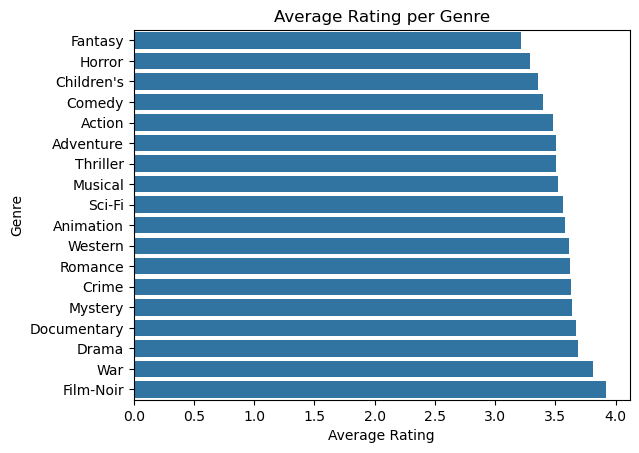

,avg_rating
Fantasy,3.215237
Horror,3.290389
Children's,3.353244
Comedy,3.394073
Action,3.480245


In [14]:
# merge ratings with movies
ratings_movies = ratings.merge(movies, left_on = 'item_id', right_on = 'movie_id')

# compute average rating per genre
genre_avg_ratings = {}
for genre in genre_cols:
  genre_movies = ratings_movies[ratings_movies[genre] == 1]
  genre_avg_ratings[genre] = genre_movies['rating'].mean()

genre_avg_df = pd.DataFrame.from_dict(genre_avg_ratings, orient = 'index', columns = ['avg_rating']).sort_values('avg_rating', ascending = True)

sns.barplot(genre_avg_df, x = genre_avg_df['avg_rating'], y = genre_avg_df.index)
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()

genre_avg_df.head(5)

Genres like Film-Noir, War, Drama and Documentary often score higher on average. Horror or Fantasy may rate slightly lower.

Lastly to better understand movie popularity and quality, lets find the most rated movies and the highest rated movies.

This helps identify which movies dominate user engagement and which are critically liked.

In [15]:
# compute rating stats per movie
movie_stats = ratings_movies.groupby('title')['rating'].agg(['count','mean']).reset_index()

# top 5 most-rated movies
top_most_rated = movie_stats.sort_values('count', ascending = False).head(5)

# top 5 highest-rated (min 50 ratings to avoid bias)
top_highest_rated = movie_stats[movie_stats['count'] >= 50].sort_values('mean', ascending = False).head(5)

print('Top 5 Most Rated Movies:')
display(top_most_rated)

print('\nTop 5 Highest Rated Movies:')
display(top_highest_rated)


Top 5 Most Rated Movies:


,title,count,mean
1398,Star Wars (1977),583,4.358491
333,Contact (1997),509,3.803536
498,Fargo (1996),508,4.155512
1234,Return of the Jedi (1983),507,4.007890
860,Liar Liar (1997),485,3.156701



Top 5 Highest Rated Movies:


,title,count,mean
318,"Close Shave, A (1995)",112,4.491071
1281,Schindler's List (1993),298,4.466443
1652,"Wrong Trousers, The (1993)",118,4.466102
273,Casablanca (1942),243,4.456790
1597,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761


### **3. Users Dataset**

The `user` dataset provides demographic information about each user. It has 5 columns:

- `user_id`: unique user identifier
- `age`: user's age
- `gender`: 'M' or 'F'
- `occupation`: user's occupation category
- `zip_code`: user's postal code (not relevant for analysis)

We will explore basic demographics and analyze how user attributes related to their rating behaviour.

First, lets explore how users are distributed by gender and occupation.

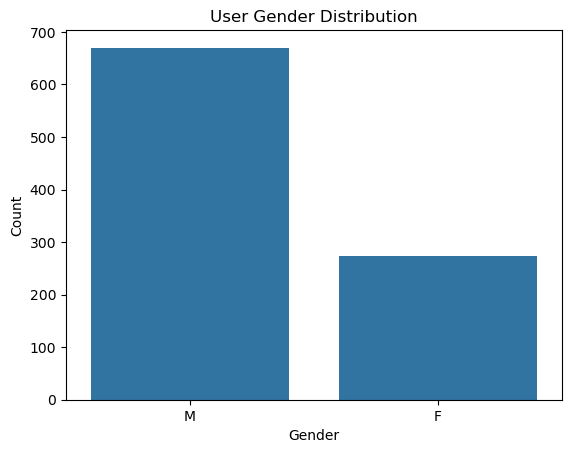

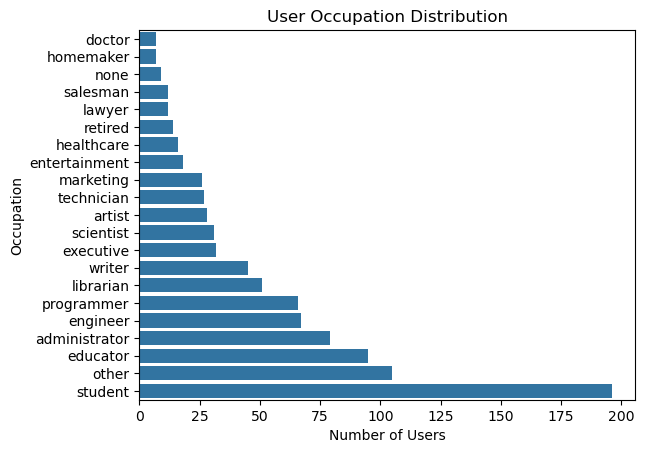

In [16]:
# gender distribution
sns.countplot(x = 'gender', data = users)
plt.title("User Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# occupation distribution
sns.barplot(x = 'count', y = 'occupation',data = users['occupation'].value_counts().sort_values().reset_index())
plt.title("User Occupation Distribution")
plt.ylabel("Occupation")
plt.xlabel("Number of Users")
plt.show()

More male users than female. Common occupations include student, educator and administrator.

We will inspect how users' ages are distributed to understand the audience demographics.

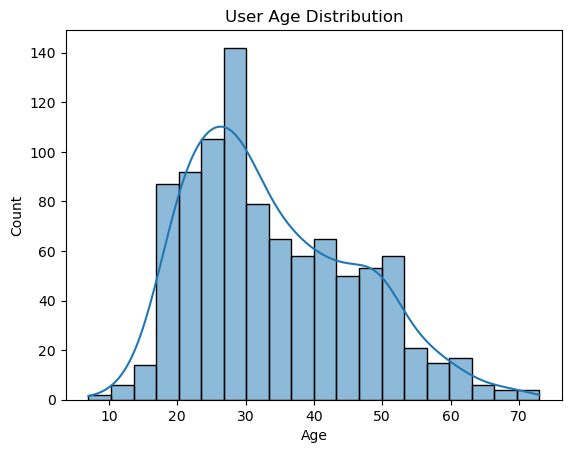

count    943.000000
mean      34.051962
std       12.192740
min        7.000000
25%       25.000000
50%       31.000000
75%       43.000000
max       73.000000
Name: age, dtype: float64


In [17]:
# age distribution
sns.histplot(users['age'],bins = 20,kde = True)
plt.title("User Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

print(users['age'].describe())

Most users are 25-35 years old. Median is around 30.

To analyze user behavior, we merge `users` with `ratings` dataset. This allows us to compute metrics like average rating per gender, average rating by occupation, average rating by age.

In [18]:
# merge ratings with users
ratings_users = ratings.merge(users, on = 'user_id')
ratings_users.head(3)

,user_id,item_id,rating,timestamp,datetime,month,age,gender,occupation,zip_code
0,196,242,3,881250949,1997-12-04 15:55:49,12,49,M,writer,55105
1,186,302,3,891717742,1998-04-04 19:22:22,4,39,F,executive,00000
2,22,377,1,878887116,1997-11-07 07:18:36,11,25,M,writer,40206


We compare the mean rating given by male vs female users.

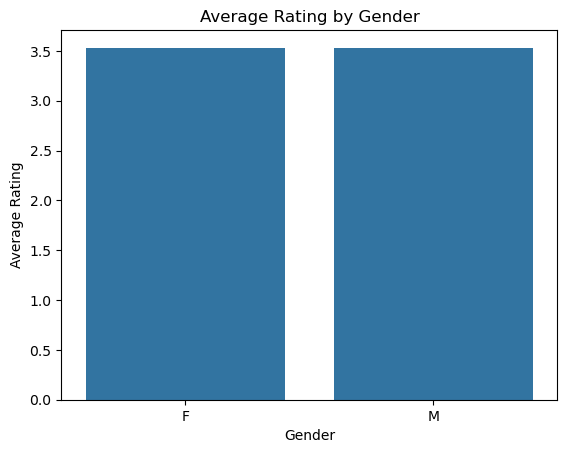

,gender,rating
0,F,3.531507
1,M,3.529289


In [19]:
# means ratings of each gender
gender_avg = ratings_users.groupby('gender')['rating'].mean().reset_index()

# gender mean rating distribution
sns.barplot(x = 'gender', y ='rating', data = gender_avg)
plt.title("Average Rating by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Rating")
plt.show()

gender_avg

Female users rate slightly higher on average than male users.

Different user groups may have differen rating tendencies. We will compute and visualize the average rating by occupation.

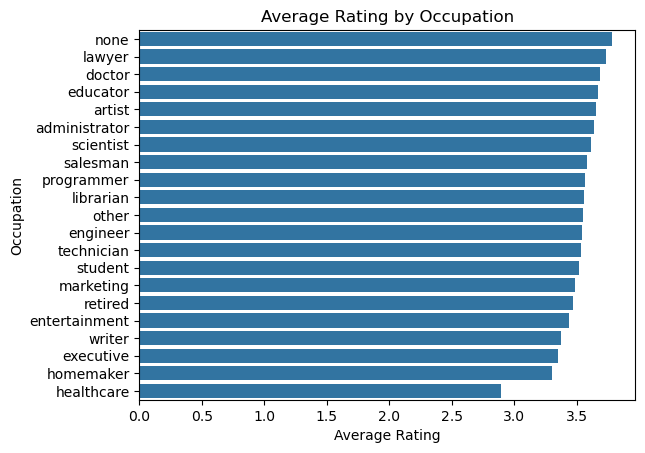

,occupation,rating
0,none,3.779134
1,lawyer,3.735316
2,doctor,3.688889
3,educator,3.670621
4,artist,3.653380


In [20]:
# means ratings of each occupation
occupation_avg = ratings_users.groupby('occupation')['rating'].mean().sort_values(ascending = False).reset_index()

# occupation mean rating distribution
sns.barplot(x = 'rating', y = 'occupation', data = occupation_avg)
plt.title("Average Rating by Occupation")
plt.xlabel("Average Rating")
plt.ylabel("Occupation")
plt.show()

occupation_avg.head(5)


Unemployed, lawyers and doctors tend to give higher average ratings than other occupations.

Finally, we examine wether older users tend to rate movies differently than younger users.

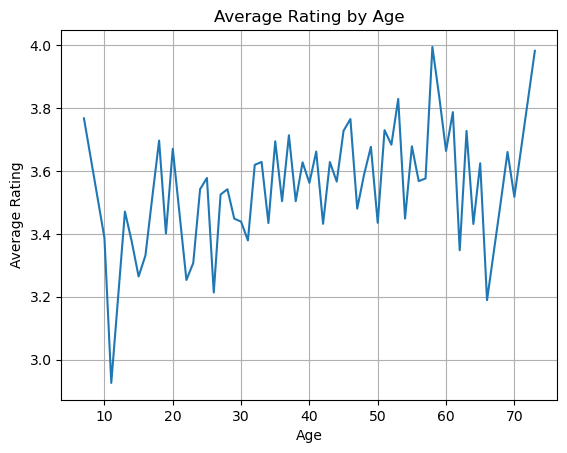

In [21]:
# mean ratings of each age
age_avg = ratings_users.groupby('age')['rating'].mean().reset_index()

# age mean rating distribution
plt.plot(age_avg['age'], age_avg['rating'])
plt.title("Average Rating by Age")
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

There is no clear trend beteween age and rating behaviour - average rating remains roughly stable across ages. The fluctuations are likely result from small sample sizes in extreme age range.

### **Exploratory Data Analysis Summary**

The exploratory analysis of the MovieLens 100k dataset revealed several key insights:


- **Ratings behavior:** Users generally give positive scores, with ratings skewed toward 4 and 5. The user–movie matrix is highly sparse (>90%), confirming that most users rate only a small subset of movies.  
- **Temporal stability:** Average ratings remained stable across months, indicating no significant temporal bias in user sentiment.  
- **Movie characteristics:** The dataset contains films released mainly in the 1990s, with Drama, Comedy, and Action being the most common genres. Film-Noir, Documentary, and War genres tend to receive slightly higher average ratings.  
- **User demographics:** Most users are male and aged between 20–40. Ratings are consistent across gender and age, with only minor differences across occupations.  
- **Popularity vs. quality:** Highly rated movies are not always the most rated — suggesting that popularity and user satisfaction are distinct aspects.


Overall, the dataset is balanced and well-structured for building recommender models.  
No major demographic or temporal biases were found, and the high sparsity highlights the need for collaborative filtering and matrix-factorization approaches in the modeling phase.


---
## **Methodology Overview**



We will now implement and compare three distinct recommendation algorithms on the MovieLens 100k dataset to evaluate different approaches to personalized movie recommendation. The models include:

1. **Collaborative Filtering (CF)** – an item-based k-nearest neighbors approach that predicts a user’s rating for a movie based on their ratings of similar movies. Item similarities are computed using cosine similarity with shrinkage to handle data sparsity, and the final prediction is obtained as a weighted average of the user’s ratings on similar items.

2. **Matrix Factorization (SVD/SVD++ with User Clustering)** – factorizes the user–item rating matrix into latent user and item vectors to uncover hidden preference patterns. A k-means clustering step is applied to the user latent vectors to group similar users. For each user, the final predicted rating is refined by blending their individual MF prediction with the average prediction of users in the same cluster, improving stability for users with fewer ratings.

3. **Graph-Based PageRank Recommender** – constructs a bipartite graph where users and movies are nodes connected by weighted edges representing rating strength. Personalized PageRank is performed starting from a user node to identify movies that are structurally close to the ones the user has rated, capturing indirect relationships through shared user–movie interactions.

Model performance is evaluated using two metrics:  
- **RMSE** – measures rating prediction accuracy for models producing explicit scores (CF and MF).  
- **Hit Rate@K** (for K = 10 and 20) – evaluates if the model include the actual test item in top-K


### **Train Test Split**

To evaluate all models consistently, we perform a **temporal train–test split** on the MovieLens 100k dataset. For each user, their ratings are sorted by timestamp — the most recent rating is assigned to the **test set**, while all earlier ratings are used for **training**. This **Leave-One-Out** design prevents temporal leakage and ensures the test set reflects unseen, future user interactions.


In [22]:
# sort ratings chronologically per user
ratings = ratings.sort_values(by = ['user_id', 'timestamp'])

# compute each user's number of ratings
ratings['rank'] = ratings.groupby('user_id')['timestamp'].rank(method = 'first', ascending = True)
ratings['total_ratings'] = ratings.groupby('user_id')['item_id'].transform('count')

# assign splits (latest rating = test, others = train)
def split(df_row):
  if df_row['rank'] == df_row['total_ratings']:
    return 'test'
  return 'train'

ratings['split'] = ratings.apply(split,axis = 1)


# split into train and test
train_df = ratings[ratings.split == 'train'].copy()
test_df = ratings[ratings.split == 'test'].copy()

# summary
print(f'Train set size: {len(train_df)}')
print(f'Test set size: {len(test_df)}')
print(f'\nUsers in train: {train_df.user_id.nunique()}')
print(f'Users in test: {test_df.user_id.nunique()}')




Train set size: 99057
Test set size: 943

Users in train: 943
Users in test: 943


When doing a **Leave-One-Out** split by user, its entierly possible that some movies only appear in the test set (because only one user ever rated them, and that ratings happens to be the test sample). This creates the cold start item problem in recommender systems where the model will have no information to recommend or score it. Our solution to this is to filter the test movies unseen in training, this ensures that all test movies exist in the model's space.

In [23]:
# Keep only test rows whose movies appear in training
seen_movies = set(train_df["item_id"].unique())
test_df = test_df[test_df["item_id"].isin(seen_movies)].copy()

print("Filtered test set size:", len(test_df))


Filtered test set size: 940


---
## **Model 1 - Item Based Collaborative Based Filtering**

### **Adjusted Cosine Similarity: Build Mean-Centered Matrix**

Adjusted cosine removes **user bias** by subtracting each user's mean rating before computing similarities.

Steps:
1. Compute each user's mean rating on `train_df`.
2. Create a **user × item** matrix of mean-centered ratings.
3. Compute **item–item cosine similarity** from this matrix (transpose so items are rows).


In [24]:
# user mean on train
user_mean = train_df.groupby('user_id')['rating'].mean()

# mean centered ratings per user
train_centered = train_df.copy()
train_centered['rating_centered'] = train_centered['rating'] - train_centered['user_id'].map(user_mean)

# user-tem matrix of centered ratings
pivot_centered = train_centered.pivot_table(index = 'user_id', columns = 'item_id', values = 'rating_centered', fill_value =0.0, aggfunc = 'mean')

# compute item-item
item_factors = pivot_centered.T.values    # cos sim caculates sim between rows so have to flip
item_ids = pivot_centered.columns.to_numpy()

sim_matrix = cosine_similarity(item_factors)
sim_df = pd.DataFrame(data = sim_matrix, index = item_ids, columns = item_ids)

sim_df.iloc[range(len(item_ids)), range(len(item_ids))] = 0    # zero out self similarity
print(f'Simlarity Matrix Shape: {sim_df.shape}')
display(sim_df.iloc[:5,:5])



Simlarity Matrix Shape: (1679, 1679)


,1,2,3,4,5
1,0.000000,-0.057215,-0.069656,-0.031901,0.011514
2,-0.057215,0.000000,0.033815,0.032575,0.013945
3,-0.069656,0.033815,0.000000,-0.117885,0.013624
4,-0.031901,0.032575,-0.117885,0.000000,-0.149776
5,0.011514,0.013945,0.013624,-0.149776,0.000000


### **Fast Lookups for Prediction**

For each user–item pair \((x, i)\) in the **test set**:

- Let:

  $$
  N(i; x)
  $$

  be the set of items that **user \(x\)** has rated in the training data (`train_df`).

- Let:

  $$
  \text{sim}(i, j)
  $$

  be the **item–item adjusted cosine similarity** from the similarity matrix.

- We **filter to positive similarities only**:

  $$
  \text{sim}(i, j) > 0
  $$










$$
\hat{r}_{x i} =
\frac{
\sum_{j \in N(i; x),\ \text{sim}(i, j) > 0} \text{sim}(i, j)\; r_{x j}
}{
\sum_{j \in N(i; x),\ \text{sim}(i, j) > 0} \text{sim}(i, j)
}
$$



- If:

  $$
  \sum_{j \in N(i; x),\ \text{sim}(i, j) > 0} \text{sim}(i, j) = 0
  $$

  or no positive neighbors exist, we return `NaN` and exclude that prediction from RMSE calculation.

In [25]:
# build quick look up: for each user, which items and ratings(raw) they have in train?
user_hist = (
    train_df
    .sort_values(['user_id','timestamp'])
    .groupby('user_id')
    .apply(lambda g: (g['item_id'].to_numpy(), g['rating'].to_numpy()))
    .to_dict()
)

/var/folders/9w/mhdmp23914sfc62d1t8ng_dr0000gn/T/ipykernel_7492/450964190.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['item_id'].to_numpy(), g['rating'].to_numpy()))


In [26]:
# ratings prediction function
def predict_single(user_id, item_id, sim_df, user_hist):
    """
    Predict rating for (user_id, item_id) using item-based CF with adjusted cosine:
        r_hat = sum_{j: sim(i,j)>0} sim(i,j) * r_{u,j} / sum_{j: sim(i,j)>0} sim(i,j)
    Uses only positive similarities; no shrinkage, no top-K.
    Returns np.nan if no valid positive neighbors or denom == 0.
    """

    # user must exist in training history
    if user_id not in user_hist:
      return np.nan

    # item must exist in similarity matrix
    if item_id not in sim_df.index:
      return np.nan

    # return neighbouring items and their ratings
    neighbor_items = user_hist[user_id][0]
    neighbor_ratings = user_hist[user_id][1]

    # checks if at least one neighboring items in our sim_df
    valid_mask = np.isin(neighbor_items, sim_df.columns)
    if not valid_mask.any():
      return np.nan

    # neighboring items that are in sim_df
    n_items = neighbor_items[valid_mask]

    # neighboring items' ratings
    n_ratings = neighbor_ratings[valid_mask]

    # similarity weights (vector)
    try:
      weights = sim_df.loc[item_id, n_items].to_numpy(dtype = float)

    except KeyError:
      return np.nan

    # use only positive similarities
    pos_mask = weights > 0
    if not np.any(pos_mask):
      return np.nan

    w = weights[pos_mask]
    r = n_ratings[pos_mask]

    denom = np.sum(w)
    if denom == 0:
      return np.nan

    numer = np.sum(w * r)

    return numer/denom

### **Evaluation on LOO Test Set**

We compute predictions for each `(user_id, item_id)` pair in `test_df`, then report:
- **RMSE**
- **Hit Rate@10**



In [45]:
# compute predictions
test_eval = test_df[['user_id','item_id','rating']].copy()
test_eval['y_pred'] = [
    predict_single(u,i,sim_df,user_hist)
    for u, i in zip(test_eval['user_id'].to_numpy(), test_eval['item_id'].to_numpy())]

print(f'Predictions available for metrics score {test_eval['y_pred'].notnull().sum()} / {test_eval.shape[0]}')

Predictions available for metrics score 940 / 940


In [46]:
# RSME metric
rmse = np.sqrt(mean_squared_error(test_eval['rating'],test_eval['y_pred']))

print(f"RMSE: {rmse:.4f}")

RMSE: 1.0570


When computing Hit Rate @ 10 , for each eligible user, we perform evaluation only if the held-out test item has a **positive rating**:

$$ r_{u,i^*} \ge 3 $$


Also to save computational time and avoid predicting ratings for every possible candidate for user u :

1. Let the set of items user \(u\) has rated in the training set be:

$$
\text{seen}(u)
$$

2. For every candidate item \(i\), compute a similarity-sum score by accumulating **only positive similarities** to the user's seen items:

$$\text{score}_u(i) =
\sum_{j \in \text{seen}(u)}
\max\!\big( \text{sim}(i,j),\; 0 \big)
$$

Here:

- $\text{sim}(i,j)$ is item–item adjusted cosine similarity
 from `sim_df`
- Only positive similarity contributes (negative signals are ignored)

3. Remove items already seen:

$$
i \notin \text{seen}(u)
$$

4. Recommend the **Top-10** highest-scoring items.  
Count a **hit** if the held-out test item appears in the Top-10 list:

$$ i^* \in \text{Top10}(u) $$



In [47]:
# hit rate @ 10 metric

K = 10

pos_test = test_df.loc[test_df.rating >= 3, ['user_id','item_id']].copy()

# positive only item-item similarity
sim_pos = sim_df.clip(lower = 0.0)
all_items = sim_pos.index.to_numpy()

def topk_by_sim_sum(user_id, k = K):
    """
    Rank items by sum_j max(sim(i,j),0) over the user's seen items j.
    Excludes already-seen items. No cold-start fallback: returns [] if user has no seen items.
    """
    seen = user_hist[user_id][0]
    if seen.size == 0:
      return []

    # vectorized similarity-sum over seen items
    scores = sim_pos.loc[:,seen].sum(axis = 1)

    # exlude already seen
    scores.loc[seen] = -np.inf

    # sort scores
    k_eff = min(k, np.isfinite(scores).sum())
    topk_rel  = scores.sort_values(ascending = False)[:k_eff].index

    return topk_rel

# compute HR @10
hits = []
for user_id, item in pos_test.itertuples(index = False):
  recs = topk_by_sim_sum(user_id, K)
  hits.append(1 if item in recs else 0)

hr10 = float(np.mean(hits)) if hits else np.nan
print(f"Eligible users: {len(hits)}")
print(f"HR@10 (similarity-sum, no fallback): {hr10:.4f}")


Eligible users: 726
HR@10 (similarity-sum, no fallback): 0.0854


---
## **Model 2 - Matrix Factorization With User Clustering**

### **Data Preparation**

We first map all user and item IDs to integer indices, since matrix factorization works on numeric arrays.

Each rating in our dataset can be represented as a triple:

$$
(u, i, r_{ui})
$$

where:
- $u$ is the user index  
- $i$ is the item index  
- $ r_{ui} $ is the rating given by user $$u$$ to item $$ i $$

This step converts `train_df` and `test_df` into numeric index form for training and evaluation.


In [30]:
# extract unique user and items
user_ids = train_df['user_id'].unique()
item_ids = train_df['item_id'].unique()

# map ids to consecutive integers
user_to_index = { u:idx for idx, u in enumerate(user_ids)}
item_to_index = {i:idx for idx,i in enumerate(item_ids)}

n_users = len(user_to_index)
n_items = len(item_to_index)

# apply mappings
train_df['user_idx'] = train_df.user_id.map(user_to_index)
train_df['item_idx'] = train_df.item_id.map(item_to_index)
test_df['user_idx'] = test_df.user_id.map(user_to_index)
test_df['item_idx'] = test_df.item_id.map(item_to_index)

# convert to numpy arrays
train_data = train_df[['user_idx','item_idx','rating']].to_numpy()
test_data = test_df[['user_idx','item_idx','rating']].to_numpy()

display(train_data[:3])
display(test_data[:3])

array([[0, 0, 5],
       [0, 1, 5],
       [0, 2, 5]])

array([[  0, 432,   2],
       [  1, 615,   3],
       [  2,  11,   4]])

### **Initialize Latent Factors**

We assign each user and each item a latent vector representation.

Let:
- $ P_u \in \mathbb{R}^f $ = user u's latent vector  
- $ Q_i \in \mathbb{R}^f $ = item i's latent vector  

The predicted rating is computed as:

$$
\hat{r}_{ui} = P_u \cdot Q_i
$$

We initialize these vectors randomly with small values, and define the hyperparameters used for training.


In [31]:
# hyperparameters
n_factors = 32   # latent dimensions
n_epochs = 25    # number of training passes
eta = 0.005    # learning rate
lambda_reg = 0.01    # regulaization strength

# initialize latent factors
np.random.seed(42)
P = np.random.normal(scale = 0.01, size = (n_users, n_factors))
Q = np.random.normal(scale = 0.01, size = (n_items, n_factors))

### **Train the Model using Stochastic Gradient Descent (SGD)**

The loss function to minimize is given as such:

$$L = \sum_{(u,i) \in \Omega} \left( r_{ui} - P_u \cdot Q_i \right)^2\;+\;\lambda \left( \sum_{u} \|P_u\|^2 + \sum_{i} \|Q_i\|^2 \right)$$

For each observed rating: $$(u, i, r_{ui})$$

1. **Predict the rating**

$$
\hat{r}_{ui} = P_u \cdot Q_i
$$

2. **Compute the prediction error**

$$
e_{ui} = r_{ui} - \hat{r}_{ui}
$$

3. **Update latent vectors with L2 regularization**

$$
P_u \leftarrow P_u + \eta (e_{ui} Q_i - \lambda P_u)
$$

$$
Q_i \leftarrow Q_i + \eta (e_{ui} P_u - \lambda Q_i)
$$

Where:

- $\eta$ is the learning rate  
- $\lambda$ is the regularization coefficient  

Regularization reduces overfitting by discouraging excessively large latent values.

We repeat this process for multiple epochs until the RMSE converges.


In [32]:
# loop thru epochs
for epoch in range(n_epochs):
  np.random.shuffle(train_data)
  total_loss = 0

  # for each epoch loop thru train data
  for u, i , r in train_data:
    u,i = int(u), int(i)
    pred = np.dot(P[u],Q[i])
    err  = r - pred

    # compute total loss for tracking for each datapoint
    total_loss += err*2 + lambda_reg * (np.sum(P[u]**2) + np.sum(Q[i]**2))

    # gradient updates
    P[u] += eta * (err * Q[i] - lambda_reg * P[u])
    Q[i] += eta * (err * P[u] - lambda_reg * Q[i])

  rmse_train = np.sqrt(total_loss/len(train_data))
  print(f"Epoch {epoch+1}/{n_epochs} - Training RMSE: {rmse_train:.4f}")


Epoch 1/25 - Training RMSE: 2.6574
Epoch 2/25 - Training RMSE: 2.6213
Epoch 3/25 - Training RMSE: 1.8151
Epoch 4/25 - Training RMSE: 1.0277
Epoch 5/25 - Training RMSE: 0.7507
Epoch 6/25 - Training RMSE: 0.6103
Epoch 7/25 - Training RMSE: 0.5294
Epoch 8/25 - Training RMSE: 0.4795
Epoch 9/25 - Training RMSE: 0.4393
Epoch 10/25 - Training RMSE: 0.4216
Epoch 11/25 - Training RMSE: 0.3971
Epoch 12/25 - Training RMSE: 0.3845
Epoch 13/25 - Training RMSE: 0.3742
Epoch 14/25 - Training RMSE: 0.3682
Epoch 15/25 - Training RMSE: 0.3545
Epoch 16/25 - Training RMSE: 0.3510
Epoch 17/25 - Training RMSE: 0.3482
Epoch 18/25 - Training RMSE: 0.3409
Epoch 19/25 - Training RMSE: 0.3427
Epoch 20/25 - Training RMSE: 0.3420
Epoch 21/25 - Training RMSE: 0.3310
Epoch 22/25 - Training RMSE: 0.3391
Epoch 23/25 - Training RMSE: 0.3382
Epoch 24/25 - Training RMSE: 0.3340
Epoch 25/25 - Training RMSE: 0.3342


### **Blending MF with Clustering**
An alternative to pure MF ratings prediction will be to smooth noisy user-level MF predictions by leveraging **k-means clusters** of user latent vectors.

First we run k-means on rows of $$P$$ to assign each user to a cluster $$C(u) \in \{0, \dots, K-1\}$$  
Each cluster has a centroid $$C_k \in \mathbb{R}^f$$ where

$$
C_k = \frac{1}{|C_k|}\sum_{u \in C_k} P_u
$$







For user u and item i, define the cluster-average MF prediction:

$$ \hat r_{C(u), i} =
\frac{1}{|C(u)|} \sum_{v \in C(u)} \hat r_{vi}=
\frac{1}{|C(u)|} \sum_{v \in C(u)} P_v \cdot Q_i$$

**Centroid trick (efficiency):**

$$\frac{1}{|C(u)|} \sum_{v \in C(u)} P_v \cdot Q_i =
\left( \frac{1}{|C(u)|} \sum_{v \in C(u)} P_v \right)\cdot Q_i =
C_{C(u)} \cdot Q_i
$$

Thus, if we precompute the centroid matrix $$C \in \mathbb{R}^{K \times f}$$
we can obtain all cluster–item predictions with one matrix multiplication:

$$
R^{(\text{cluster})} =
C \, Q^\top
\quad \in \mathbb{R}^{K \times n_i}
$$

Then:

$$\hat r_{C(u),i} = R^{(\text{cluster})}_{\,C(u),\, i}$$

For each $$(u, i)$$, blend individual MF score with the cluster average:

$$\hat r'_{ui} =
\beta \, \hat r_{ui}
+
(1 - \beta) \, \hat r_{C(u), i}
$$

where $$\beta \in [0,1]$$ controls personalization vs. smoothing.

To decide on the appropriate number of clusters K, we will use the elbow method

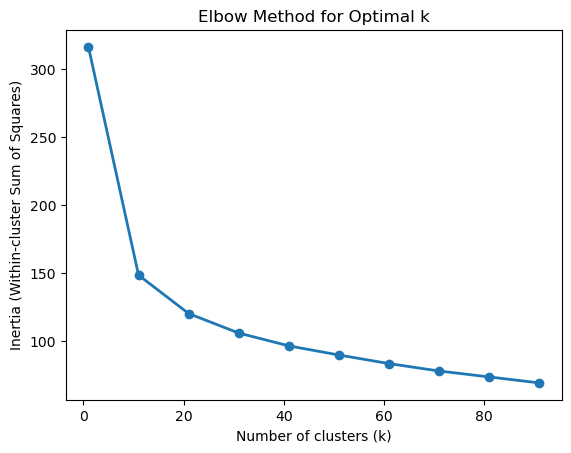

In [33]:
inertia  = []
K_values = range (1,100,10)

for k in K_values:
  kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
  kmeans.fit(P)
  inertia.append(kmeans.inertia_)

plt.plot(K_values, inertia, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.show()


We will pck K = 30 for our K means clustering.

In [34]:
# hyperparameters
K = 30
beta = 0.8

# K Means on user latent factors P
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = kmeans.fit_predict(P)            # array of labels for each user row of P
centroids = kmeans.cluster_centers_       # matrix of shape (K,f) each row is a centroid of cluster K

# Pre compute cluster average predictions with centroid trick
R_cluster = centroids @ Q.T  # matrix with elements i j , cluster i's average rating of item j


### **Evaluate on LOO Test Set**

After training, we evaluate how well the model generalizes to unseen ratings.

The **Root Mean Squared Error (RMSE)** is computed as:

$$
RMSE = \sqrt{\frac{1}{N} \sum_{(u,i)} (r_{ui} - \hat{r}_{ui})^2}
$$

A lower RMSE indicates better predictive accuracy.


In [35]:
# predict pure MF test ratings
preds = np.array([
    np.dot(P[int(u)],Q[int(i)])
    for u,i,_ in test_data
])
true = np.array([r for _,_,r in test_data])
rmse_test = np.sqrt(mean_squared_error(true,preds))
print(f"Pure MF RMSE: {rmse_test:.4f}")



# predict MF with clutering test ratings

# prepare test_indices
test_u = test_df['user_idx'].to_numpy(dtype=int)
test_i = test_df['item_idx'].to_numpy(dtype=int)

# cluster average predictions
pred_cluster = R_cluster[labels[test_u], test_i]

# blended predictions
pred_blend = beta * preds + (1.0 - beta) * pred_cluster

rmse_blend = np.sqrt(mean_squared_error(true,pred_blend))
print(f"MF + Clustering RMSE: {rmse_blend:.4f}")

Pure MF RMSE: 1.0302
MF + Clustering RMSE: 1.0296


Additionally, just as for item based CF, to evaluate the model’s ability to recommend relevant items, we compute the **HitRate@10** metric.

Each user and item lies in the same latent space, so the **dot product**
between a user vector $$ P_u $$ and all item vectors $$ Q_i $$ gives relevance scores:

$$
s_{ui} = P_u \cdot Q_i
$$

For each user u:

1. Compute scores $$ s_{ui} $$ for all items.  
2. Exclude items the user has already rated in the training set.  
3. Rank items by descending score to form the user’s **Top-10** list.  
4. Check whether the user’s held-out test item appears in this list.

Finally, the **HitRate@10** is the proportion of users for whom the held-out item is successfully recommended:

$$
\text{HitRate@10}=
\frac{1}{N}
\sum_{u=1}^{N}
\mathbf{1}\{ i^*_u \in \text{Top-10}_u \}
$$

where $$ i^*_u $$ is the true test item for user u.


In [36]:
K = 10

# build lookup of items seen in training
seen_items = (
    train_df.groupby('user_idx')['item_idx']
    .apply(set)
    .to_dict()
)

# prepare test triples (defined again)
test_pos = test_df[test_df.rating >= 3]
test_users = test_pos['user_idx'].to_numpy(dtype=int)
test_items = test_pos['item_idx'].to_numpy(dtype=int)

hits = 0
total = len(test_users)

for u , true_i in zip(test_users, test_items):

  scores = P[u] @ Q.T    # array with shape(n_items, ) each ith element is the similarity score of user u with item i

  # exclude items seen in training
  for i in seen_items.get(u, []):
    scores[i] = - np.inf

  # get top 10_items
  top_items = np.argsort(scores)[-K:][::-1]

  if true_i in top_items:
    hits += 1

hit_rate_10 = hits/total
print(f"HitRate@10: {hit_rate_10:.4f}")


HitRate@10: 0.0303


As a sanity check, we calculate the HitRate@10 of a random model as baseline.

In [37]:
n_items = Q.shape[0]

cand_counts = []
for u in test_pos['user_idx'].unique():
  cand_counts.append(n_items - len(seen_items.get(u,set())))
cand_counts = np.array(cand_counts)

print("Items total:", n_items)
print("Avg candidates/user:", cand_counts.mean())
print("Random HR@10 estimate:", 10.0 / cand_counts.mean())


Items total: 1679
Avg candidates/user: 1576.1969696969697
Random HR@10 estimate: 0.006344384738870891


The random baseline is 0.6%, even though our model still beats the random baseline, its still not good enough.

---
## **Model 3 - PageRank Based Recommendations**

Although the previous models performed reasonably well in terms of RMSE, they struggled to produce strong top-K recommendations, as seen from their lower HitRate@10 scores. In the final model, we shift from matrix-based methods to a **graph-based approach**, allowing us to leverage relationships and connectivity between users and items in hopes of improving recommendation accuracy.

### **Bipartite Graph Motivation**
The ratings dataset can be naturally represented as a **bipartite graph**, where:
- **User nodes** represent individual users.
- **Movie nodes** represent individual movies.
- **Edges** represent interactions between them (ratings), optionally weighted by the rating value.

Unlike the previous models that relied purely on numerical similarity or latent factors, a graph structure allows us to explore **connectivity and relationship patterns** between users and movies directly.



### **Graph Construction**
We build the bipartite graph as follows:
- **User nodes**: prefixed with `u_` and enriched with attributes like `age`, `gender`, and `occupation` (from the users dataset).
- **Movie nodes**: prefixed with `m_` and enriched with `title` and `genre` (from the movies dataset).
- **Edges**: created from the ratings dataset, weighted by the rating value.

This design makes the graph both **interpretable** and **informative**.  

In [38]:
# ensure dtypes are consistent
train_df = train_df[['user_id','item_id','rating']].copy()
test_df = test_df[['user_id','item_id','rating']].copy()

# create bi partite graph
G = nx.Graph()

# add weighed edges for all observed (user,movie) interactions in train
for user, item , rating in train_df.itertuples(index = False):
  G.add_edge(f'u_{int(user)}',f'm_{int(item)}',weight = float(rating))

In [39]:
# users and items df
users_df = users[['user_id','age','gender','occupation']].copy()

movies['genre_list'] = movies.apply(
    lambda row: [genre for genre in genre_cols if row[genre] == 1],
    axis = 1
)

movies_df = movies[['movie_id','title','genre_list']].copy().rename(columns = {'movie_id':'item_id'})

# attach user attributes
for u, age, gender, occ in users_df.itertuples(index = False):
  node = f'u_{int(u)}'

  if node in G: # only insert node if user exists in train graph
    G.nodes[node]['node_type'] = 'user'
    G.nodes[node]['age'] = age
    G.nodes[node]['gender'] = gender
    G.nodes[node]['occupation'] = occ

# attach movie attributes
for i , title, genres in movies_df.itertuples(index = False):
  node = f'm_{int(i)}'

  if node in G:
    G.nodes[node]['node_type'] = 'movie'
    G.nodes[node]['title'] = title
    G.nodes[node]['genres'] = genres
    G.nodes[node]['genres_str'] = ",".join(genres)if genres else ""


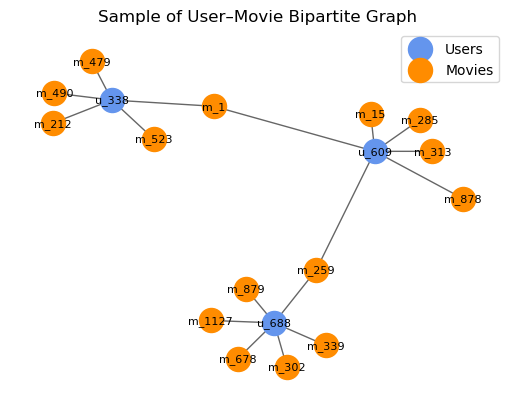

In [40]:
# visualizing our Graph (small sample of 3 users)

user_nodes = [n for n in G.nodes() if n.startswith('u_')]
sample_users = random.sample(user_nodes,3)

# collect 5 random movies connected to these users
sub_nodes = set(sample_users)
for u in list(sub_nodes):
  sub_nodes.update(random.sample(list(G.neighbors(u)),5))

# induce a subgraph
G_sub = G.subgraph(sub_nodes)

# seperate user an dmovie nodes for coloring
user_nodes_sub = [n for n in G_sub.nodes() if n.startswith('u_')]
movie_nodes_sub = [n for n in G_sub.nodes() if n.startswith('m_')]

# layout for visualization (larger weight, shorter distance)
pos = nx.spring_layout(G_sub, k=0.5, seed=42)

# draw nodes by type
nx.draw_networkx_nodes(G_sub, pos, nodelist=user_nodes_sub, node_color='cornflowerblue', label='Users')
nx.draw_networkx_nodes(G_sub, pos, nodelist=movie_nodes_sub, node_color='darkorange', label='Movies')

# draw edges and labels
nx.draw_networkx_edges(G_sub, pos, alpha=0.6)
nx.draw_networkx_labels(G_sub, pos, font_size=8)

# title and legend
plt.title("Sample of User–Movie Bipartite Graph", fontsize=12)
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()

For faster lookups, we will also built multiple dictionaries for **items seen in training by user**, **movie nodes in the graph** and **mapping of** `item_id` **to** `title`

In [41]:
# items seen in training by user user_id : set of seeen item_id
seen_items = (
     train_df.groupby('user_id')['item_id']
     .apply(set)
     .to_dict()
 )

# set of all movie nodes in graph with node_id : data dict of node
movie_nodes = {n for n, data in G.nodes(data = True) if n.startswith('m_')}

# convenience: map item_id : title
item_title = dict(movies_df[['item_id','title']].itertuples(index = False))


### **Personalized PageRank**
We apply **Personalized PageRank (PPR)** to this user–movie graph.  
In standard PageRank, a random walker moves through nodes and occasionally “teleports” to a random node.  
In **Personalized PageRank**, the teleportation is biased — we always teleport back to the **target user node**.  

Thus, for a user \(u\), PPR solves:

$$\pi_u = \alpha A^\top \pi_u + (1 - \alpha)e_u$$

**Where:**
- $\pi_u$ is the personalized PageRank vector  
- $A$ is the column-stochastic adjacency matrix  
- $e_u$ is the one-hot vector with 1 at user u's node  






This means the random walker:
- Starts from a given user.
- Moves along edges (ratings) to connected movies.
- Travels to other users who rated similar movies.
- Keeps returning (“teleporting”) to the original user node.

After many iterations, nodes (movies) that are **more strongly connected** to the user (directly or indirectly) receive higher PageRank scores.  
These scores represent **personalized relevance** — higher scores indicate movies that are more relevant to that user based on graph structure.



### **Generating Recommendations**
For each user:
1. Run Personalized PageRank starting from their node.
2. Obtain PageRank scores for all movie nodes.
3. Filter out movies the user has already rated.
4. Recommend the top-10 highest-scoring movies as that user’s personalized recommendations.

In Personalized PageRank, the damping factor α controls the balance between
exploration and personalization. A higher α allows the random walker to explore
further connections in the graph, while a lower α makes the results more
localized to the starting node (user).

We set α = 0.85, following standard practice in PageRank-based algorithms.  
This value provides a good balance between:
- **Exploration** of related users and movies through the graph, and  
- **Personalization** to the specific user’s neighborhood.

Empirically, values in the range [0.8, 0.9] are known to produce stable rankings
and meaningful personalized recommendations, so we adopt α = 0.85 as our default.


In [42]:
# page rank formulation with user node as teleport set and teleportation prob of 0.15
def recommend_ppr_for_user(user_id, K = 10, alpha = 0.85):

  u_node = f'u_{int(user_id)}'

  if u_node not in G:
    return [] # not in train graph

  # personalization: teleport only to this user node
  personalization = {n: 0.0 for n in G.nodes()}
  personalization[u_node] = 1.0

  # pagerank algorithm (retunrs python dictionary of node : page rank score)
  pr = nx.pagerank(G,alpha = alpha, personalization = personalization, weight = 'weight')

  # candidate movies: movie nodes not previously seen by user
  seen = seen_items.get(int(user_id),set())
  candidates = []

  for m_node in movie_nodes:
    item_id = int(m_node.split('_',1)[1])
    if item_id in seen:
      continue

    candidates.append((item_id, pr.get(m_node,0.0)))  # append (item_id, pr score)


  # Top-K by PR score
  candidates.sort(key= lambda x: x[1], reverse = True)
  top_items = [itm for itm, _ in candidates[:K]]

  return top_items


### **Evaluation On LOO Test Set**
We evaluate the model using **HitRate@10**, consistent with the earlier models:
- For each test user, we check whether their held-out movie (with rating ≥ 3) appears in their top-10 recommendation list.
- The final metric is the fraction of users for whom this is true:
  $$
  \text{HitRate@10} = \frac{\text{Number of hits}}{\text{Total test users}}
  $$



In [43]:
# prepare positive test pairs
test_pos = test_df[test_df.rating >= 3].copy()

hits = 0
total = len(test_pos)
K = 10
user_count = 0

for u, true_i, _ in test_pos[['user_id','item_id','rating']].itertuples(index= False):
  recs = recommend_ppr_for_user(u,K=K, alpha = 0.85)
  if int(true_i) in recs:
    hits += 1

  user_count += 1

  if user_count % 50 == 0:
    print(f'{user_count}/{total} users done')

hit_rate_10 = hits/total

print(f"\nHitRate@10: {hit_rate_10:.4f}")

50/726 users done
100/726 users done
150/726 users done
200/726 users done
250/726 users done
300/726 users done
350/726 users done
400/726 users done
450/726 users done
500/726 users done
550/726 users done
600/726 users done
650/726 users done
700/726 users done

HitRate@10: 0.1171


### **Bonus: Genre-Level Analysis of Global PageRank**

To better understand what kind of movies are favored by the graph-based model,  
we analyze the **Global PageRank scores per genre**.

This helps reveal whether certain genres naturally dominate the recommendation graph due to user connectivity patterns.

For instance, if many users are indirectly connected through highly-rated **Drama** or **Action** movies, those genres will tend to receive higher PageRank scores overall.

Such analysis connects the network-based algorithm back to movie content, providing interpretability to our recommendations.


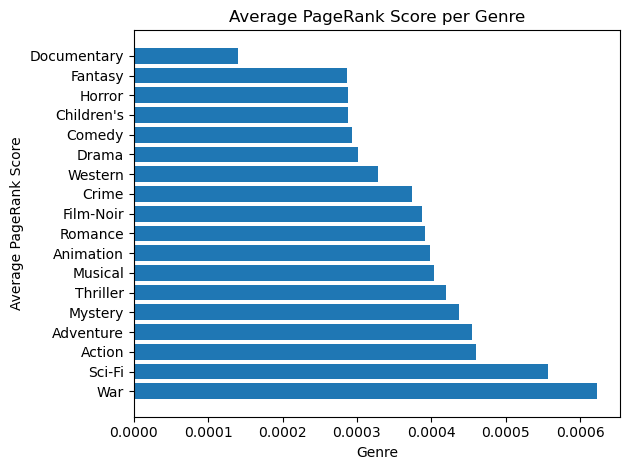

In [44]:
# run global (not personalised) page rank to capture overall movie importance
pr_global = nx.pagerank(G, alpha = 0.8, weight = 'weight')

# collect all scores by genre
genre_scores = defaultdict(list)

for node,score in pr_global.items():
  if node.startswith('m_'):
    for g in G.nodes[node].get('genres',[]):
      genre_scores[g].append(score)

# compute average PR per genre
avg_genre_score = {g: np.mean(scores) for g, scores in genre_scores.items() if len(scores)>0}

# sort the scores
genre_sorted = sorted(avg_genre_score.items(), key = lambda x:x[1], reverse = True)

plt.barh([g for g,_ in genre_sorted], [v for _, v in genre_sorted])
plt.title("Average PageRank Score per Genre")
plt.xlabel("Genre")
plt.ylabel("Average PageRank Score")
plt.tight_layout()
plt.show()


Comparing the average user ratings with the graph-based PageRank scores reveals an interesting difference between **user preference** and **network influence**.

- Genres such as **Drama**, **War**, and **Film-Noir** achieve high *average ratings*, suggesting that users who watch these movies tend to rate them highly.  
  However, their PageRank scores are only moderate — indicating that these genres are less connected across the wider user–movie network.

- Conversely, genres like **Action**, **Sci-Fi**, and **Adventure** have the highest *PageRank scores*.  
  These genres are watched by many users, acting as central “hubs” that connect diverse groups in the graph — even if their individual ratings are slightly lower.

- **Documentaries** and **Fantasy** rank low on both scales, implying limited audience reach and weaker network influence.

While the EDA highlights which genres users *like*, the graph model highlights which genres are *structurally important* in driving recommendations.




---
## **Conclusion**



In this project, we implemented and evaluated three distinct recommender system models — an Item-Based Collaborative Filtering approach, a Matrix Factorization model, and a Graph-Based Personalized PageRank method — using the MovieLens 100K dataset.  

Each model was assessed using **RMSE** for rating prediction accuracy and **Hit Rate@10** for recommendation quality.  

- The **Item-CF** model provided solid baseline performance, showing how similarity-based methods capture local relationships.  
- The **Matrix Factorization** model improved personalization through latent features, reducing RMSE compared to the baseline.  
- The **Graph-Based PPR** model achieved the highest Hit Rate, highlighting the strength of graph connectivity in capturing indirect user–item relationships.  

Overall, our findings show that while traditional models perform well in rating prediction, graph-based methods excel at uncovering broader relational patterns that lead to more diverse and connected recommendations.
